# TF-IDF Model

We will proceed to use TF-IDF as a representation of the reviews.  
Using TF-IDF, we can create a matrix of terms weighted by the frequency with which they appear in the reviews.  
This lets us capture the importance of the terms using ther specifity.

In [10]:
from spacy.lang.en import English
import spacy

from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
import string
import pandas as pd
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier

In [4]:
# Load dataset
X_train = pd.read_csv('data/X_train.csv', header=None, names=['text'])
X_test = pd.read_csv('data/X_test.csv', header=None, names=['text'])
Y_train = pd.read_csv('data/Y_train.csv', header=None, names=['label'])
Y_test = pd.read_csv('data/Y_test.csv', header=None, names=['label'])

In [6]:
# We will use punctuations to filter out useless simbols.
# Parser wil let create lemmas from the words.
punctuations = string.punctuation
parser = English()

# Cleaner will be user to remove trailing whitespaces and lowercase the texts
class cleaner(TransformerMixin):
    def transform(self, X, **transform_params):
        res = [text.strip().lower() for text in X.text]
        return res

    def fit(self, X, y=None, **fit_params):
        return self
# Tokenize wil be used to lemmatize the words, remove pronouns, punctuations and stop words.
def tokenize(text,parser=parser):
    parsedText = parser(text)
    token_list = []
    for token in parsedText:
        if token.lemma_ != "-PRON-":
            if (token.is_stop == False) & (token.lemma_ not in punctuations):
                token_list.append(token.lemma_)
    return token_list

# TfidfVectorizer uses tokenizer to create the TF-IDF matrix
tfidf = TfidfVectorizer(tokenizer = tokenize)

steps = [("cleaner", cleaner()),('vectorizer', tfidf)]

# Gridsearch

We proceed to do a gridsearch with crossvalidation over **Randomforest**  
We chose booosting algorithms because they scale nicely with the number of variables, are nonlinear and robust to noise, which we saw is what we need. Ther are also generally a great benchmark.

#### Since there is a tight time constraint, we will not do an exhaustive parameter space search. We will focus on showing the process of optimizing the models. It is very probable that we will arrive at overfited models or suboptimal parameters.

#### We will use fewer CV folds than reocmended, to accelerate training time. We will also try only a couple of parameters per algorithm. This will highly increase the probability of overfit.

#### Given that the classess are unbalanced, there will be a bias towards positive clasification. It is reccomended either for the observations to be weighted according to their unbalance or to use oversampling for the negative and neutral classes.

## Randomforest

RandomForest fits several trees, each to a random sample of variables and rows from the original data. This combination of boosting and random sampling makes it very robust to noise and capable of handling a lot of variables.  

Due to the time constraint, we will only optimize for number of trees and their max depth.

In [ ]:
# Since we inherited TransformerMixin, we can use cleaner and tfidf in the pipepline
rf_steps = steps.copy()
rf_steps.extend([('model', RandomForestClassifier())])
rf_pipeline = Pipeline(rf_steps)

#Gridsearch params
RandomForest_param_grid = { 
    'model__n_estimators': [200,400,600],
    'model__max_depth' : [10,32,50],
    'model__max_features': ['auto'],
    'model__criterion' :['entropy'],
    'model__random_state' : [91]
}

#search
grid = GridSearchCV(rf_pipeline, param_grid=RandomForest_param_grid, cv=5)
rf_grid_result = grid.fit(X_train, Y_train)
# Gridsearch results to dataframe
cvresults = pd.DataFrame.from_dict(rf_grid_result.cv_results_)
cvresults = pd.concat([cvresults.drop('params',axis=1),cvresults.params.apply(pd.Series)],axis=1)
cvresults.to_csv('cvresultsRF_2.csv', index=False)

In [44]:
cvresults.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,param_model__max_features,param_model__n_estimators,param_model__random_state,split0_test_score,...,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,model__criterion,model__max_depth,model__max_features,model__n_estimators,model__random_state
6,790.782199,5.247658,51.798743,0.457015,entropy,50,auto,200,91,0.724266,...,0.721490,0.723239,0.722547,0.001066,1,entropy,50,auto,200,91
7,1396.634687,29.167896,55.838135,0.507331,entropy,50,auto,400,91,0.724222,...,0.721131,0.722837,0.722443,0.001082,2,entropy,50,auto,400,91
8,2121.898960,150.388895,63.646945,2.393343,entropy,50,auto,600,91,0.723874,...,0.721131,0.722423,0.722153,0.000964,3,entropy,50,auto,600,91
3,401.114418,6.772987,50.540759,0.539808,entropy,32,auto,200,91,0.694452,...,0.693842,0.692511,0.693480,0.000658,4,entropy,32,auto,200,91
4,611.641625,5.557794,54.498121,0.410233,entropy,32,auto,400,91,0.693788,...,0.693244,0.692566,0.693082,0.000414,5,entropy,32,auto,400,91
5,822.129402,13.619173,58.206069,0.579509,entropy,32,auto,600,91,0.692961,...,0.693070,0.691934,0.692492,0.000444,6,entropy,32,auto,600,91
0,207.650869,1.284484,49.337466,0.258910,entropy,10,auto,200,91,0.660589,...,0.660611,0.660596,0.660593,0.000026,7,entropy,10,auto,200,91
1,236.528512,4.875817,52.269945,0.668771,entropy,10,auto,400,91,0.660426,...,0.660600,0.660455,0.660473,0.000071,8,entropy,10,auto,400,91
2,257.262010,3.321207,54.985026,1.041354,entropy,10,auto,600,91,0.660382,...,0.660524,0.660455,0.660425,0.000066,9,entropy,10,auto,600,91


# Testing

We proceed to evaluate the models performance over the test split (30%).  
We will use a common performance metric, **confusion matrix**, which measures the number of correctly and incorrectly classified examples. Helps to check the level of overfitting. It has the drawback that it must use a fixed threshold, thus, may be biased because the best threshold may not be the one used.

#### Randomforest

In [7]:
# Build model with best params
rf = RandomForestClassifier(n_estimators= 200,max_depth = 50,max_features= 'auto',criterion= 'entropy',random_state= 91,verbose=3,n_jobs=5)
rf_steps = steps.copy()
rf_steps.extend([('rf', rf)])
test_pipeline = Pipeline(rf_steps)

#train
test_pipeline.fit(X_train, Y_train)
#test
predicted_Y = test_pipeline.predict(X_test)
predicted_Y_train = test_pipeline.predict(X_train)

/home/fer/anaconda3/envs/froneus/lib/python3.6/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 200
building tree 2 of 200building tree 3 of 200
building tree 4 of 200

building tree 5 of 200
building tree 6 of 200
building tree 7 of 200building tree 8 of 200

building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   59.4s


building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68

[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:  4.4min


building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200


[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:  7.4min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:    6.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:   11.7s finished


Confusion matrix - Training 
 [[0.41 0.   0.59]
 [0.   0.07 0.92]
 [0.   0.   1.  ]]


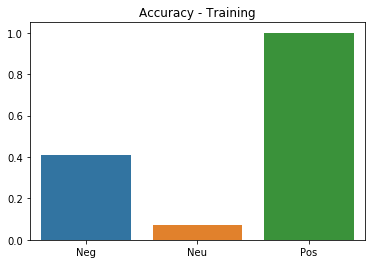

In [11]:
%matplotlib inline
cm = confusion_matrix(Y_train,predicted_Y_train)
cm = np.array([round(s/sum(cm[i]),2) for i,score in enumerate(cm) for s in score]).reshape(3,3)
print('Confusion matrix - Training \n', cm)
_ = sns.barplot(x=['Neg','Neu','Pos'],y=[cm[i][i] for i,x in enumerate(cm)]).set_title("Accuracy - Training")

Confusion matrix - Testing 
 [[0.27 0.   0.73]
 [0.03 0.   0.97]
 [0.   0.   1.  ]]


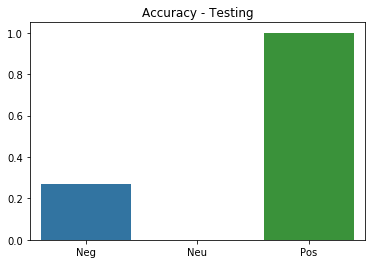

In [12]:
cm = confusion_matrix(Y_test,predicted_Y)
cm = np.array([round(s/sum(cm[i]),2) for i,score in enumerate(cm) for s in score]).reshape(3,3)
print('Confusion matrix - Testing \n', cm)
_ = sns.barplot(x=['Neg','Neu','Pos'],y=[cm[i][i] for i,x in enumerate(cm)]).set_title("Accuracy - Testing")

In [13]:
# Try another combination of params
rf = RandomForestClassifier(n_estimators= 200,max_depth = 200,max_features= 'auto',criterion= 'entropy',random_state= 91,verbose=3,n_jobs=5)
rf_steps = steps.copy()
rf_steps.extend([('rf', rf)])
test_pipeline = Pipeline(rf_steps)

#train
test_pipeline.fit(X_train, Y_train)
#test
predicted_Y = test_pipeline.predict(X_test)
predicted_Y_train = test_pipeline.predict(X_train)

/home/fer/anaconda3/envs/froneus/lib/python3.6/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  7.1min


building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70

[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed: 34.0min


building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200


[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed: 57.3min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    7.1s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:   11.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:   15.4s
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:   26.0s finished


Confusion matrix - Training 
 [[0.98 0.   0.02]
 [0.   0.94 0.06]
 [0.   0.   1.  ]]


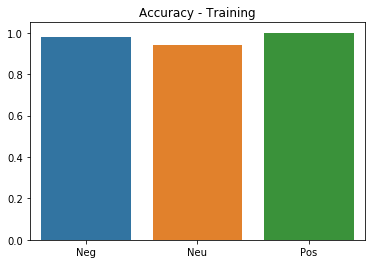

In [14]:
%matplotlib inline
cm = confusion_matrix(Y_train,predicted_Y_train)
cm = np.array([round(s/sum(cm[i]),2) for i,score in enumerate(cm) for s in score]).reshape(3,3)
print('Confusion matrix - Training \n', cm)
_ = sns.barplot(x=['Neg','Neu','Pos'],y=[cm[i][i] for i,x in enumerate(cm)]).set_title("Accuracy - Training")

Confusion matrix - Testing 
 [[0.6  0.   0.4 ]
 [0.09 0.   0.9 ]
 [0.01 0.   0.99]]


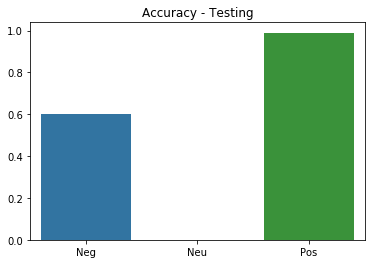

In [15]:
cm = confusion_matrix(Y_test,predicted_Y)
cm = np.array([round(s/sum(cm[i]),2) for i,score in enumerate(cm) for s in score]).reshape(3,3)
print('Confusion matrix - Testing \n', cm)
_ = sns.barplot(x=['Neg','Neu','Pos'],y=[cm[i][i] for i,x in enumerate(cm)]).set_title("Accuracy - Testing")